In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
import re
sns.set(font_scale=1.4, style="whitegrid")

In [2]:
tempos = ["010", "020", "030"]
tempoEstavel = 100
seeds = ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100"]
quantidadeIperfs = 2500
salvarGraficos = True
#Tabela tempo->medicao
#010 -> 100=18 250=48
#020 -> 150=28 300=58
#030 -> 200=38 350=68
#intervalosEstaveis = [("010", 18, 48), ("020", 28, 58), ("030", 38, 68)]
intervalosEstaveis = [("010", 28, 48), ("020", 38, 58), ("030", 48, 68)]
intervalosTempo = [("010", 150, 250), ("020", 200, 300), ("030", 250, 350)]

In [3]:
#Adicionando colunas com a medicao
mHW = 0
mSW = 0
def teste (nomeSwitch):
    global mHW
    global mSW
    if (nomeSwitch == "HW"):
        mHW += 1
        return mHW
    if (nomeSwitch == "SW"):
        mSW += 1
        return mSW

#Lendo os arquivos info (report do controlador)
dfPI_info = pd.DataFrame()
dfSW_info = pd.DataFrame()
i = 1
for seed in seeds:
    mHW = 0
    mSW = 0
    for tempo in tempos:
        mHW = 0
        mSW = 0
        dfPI_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_infoTemp['TempoChegada'] = tempo
        dfPI_infoTemp['Seed'] = seed
        dfPI_infoTemp['Metodo'] = 'Estático'
        dfPI_infoTemp['Medicao'] = dfPI_infoTemp['Switch'].apply(teste)
        dfPI_info = pd.concat([dfPI_info, dfPI_infoTemp], ignore_index=True)
        mHW = 0
        mSW = 0
        dfSW_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_infoTemp['TempoChegada'] = tempo
        dfSW_infoTemp['Seed'] = seed
        dfSW_infoTemp['Metodo'] = 'Dinâmico'
        dfSW_infoTemp['Medicao'] = dfSW_infoTemp['Switch'].apply(teste)
        dfSW_infoTemp.rename(columns={'VezesBloqueado':'RegrasBloqueadas'}, inplace=True)
        dfSW_info = pd.concat([dfSW_info, dfSW_infoTemp], ignore_index=True)
    i += 1
dfTotal_info = pd.concat([dfPI_info, dfSW_info], ignore_index=True)
#dfTotal_info.to_csv(r'pandas.txt', index=None, sep=' ', mode='a')

In [4]:
#Lendo todos os CSVs dos iperfs
dfPI_csv = pd.DataFrame()
dfSW_csv = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/teste"+(str(i))+"_pi"+(tempo)+".csv")
        dfPI_csvTemp['TempoChegada'] = tempo
        dfPI_csvTemp['Seed'] = seed
        dfPI_csvTemp['Metodo'] = 'PI'
        dfPI_csv = pd.concat([dfPI_csv, dfPI_csvTemp], ignore_index=True)
        dfSW_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/teste"+(str(i))+"_sw"+(tempo)+".csv")
        dfSW_csvTemp['TempoChegada'] = tempo
        dfSW_csvTemp['Seed'] = seed
        dfSW_csvTemp['Metodo'] = 'SW'
        dfSW_csv = pd.concat([dfSW_csv, dfSW_csvTemp], ignore_index=True)
    i += 1
del dfPI_csv['?']
del dfSW_csv['?']
del dfSW_csv['Timestamp']
del dfPI_csv['Timestamp']
dfServerPI = dfPI_csv[dfPI_csv.IpOri == '10.1.0.1']
dfServerSW = dfSW_csv[dfSW_csv.IpOri == '10.1.0.1']
dfServer = pd.concat([dfServerPI, dfServerSW], ignore_index=True)

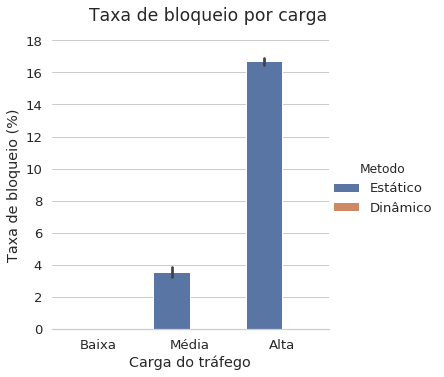

In [16]:
#Grafico de bloqueados metodo par impar
gpb = dfTotal_info.groupby(["Seed", "TempoChegada", "Metodo"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(quantidadeIperfs)*100
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "Alta", "020": "Média", "030": "Baixa"})
sns_plt = sns.catplot(x="NomeTempo", y="TaxaBloqueio", kind="bar", orient='v', hue="Metodo", hue_order=["Estático", "Dinâmico"],order=["Baixa", "Média", "Alta"], ci=95, data=gpb)
sns_plt.fig.suptitle('Taxa de bloqueio por carga', y=1.05)
sns_plt.set(ylim=(0, 18))
sns_plt.set_axis_labels("Carga do tráfego", "Taxa de bloqueio (%)")
sns_plt.despine(left=True)
if (salvarGraficos):
    sns_plt.savefig("TaxaBloqueio.pdf")

Podemos observar que o método estático bloqueia novos tráfegos tanto na carga baixa quanto na carga alta, sendo a última uma taxa bem elevada (mais de 16% dos tráfegos iniciados são bloqueados). Todos estes bloqueios são causados no switch de hardware, que tem uma tabela de tamanho reduzido. Já no método dinâmico, a taxa de bloqueio é 0 em todos os testes, já que todas as regras dos novos tráfegos são instaladas inicialmente no switch de software, que possui um tamanho de tabela muito grande.

In [6]:
#Trafego em cada switch (total de gigabytes)
# gpb = dfTotal_info.groupby(["Metodo", "TempoChegada", "Seed", "Switch"]).max()
# gpb["GBEnv"] = gpb["BytesEnviados"]/1e9
# gpb.reset_index(inplace=True)
# gpb["Switch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
# gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
# sns_plt = sns.catplot(palette="Accent", x="Metodo", y="GBEnv", kind="bar", ci=95, data=gpb, col="NomeTempo", hue="Switch", col_order=["baixa", "alta"], order=["Estático", "Dinâmico"])
# sns_plt.set(ylim=(0, 14))
# sns_plt.fig.suptitle('Total de gigabytes transmitidos por switch', y=1.05)
# sns_plt.set_axis_labels("Carga do tráfego", "Gigabytes transmitidos")
# sns_plt.set_titles("Carga {col_name}")
# if (salvarGraficos):
#     sns_plt.savefig("totalgbporswitch.pdf")

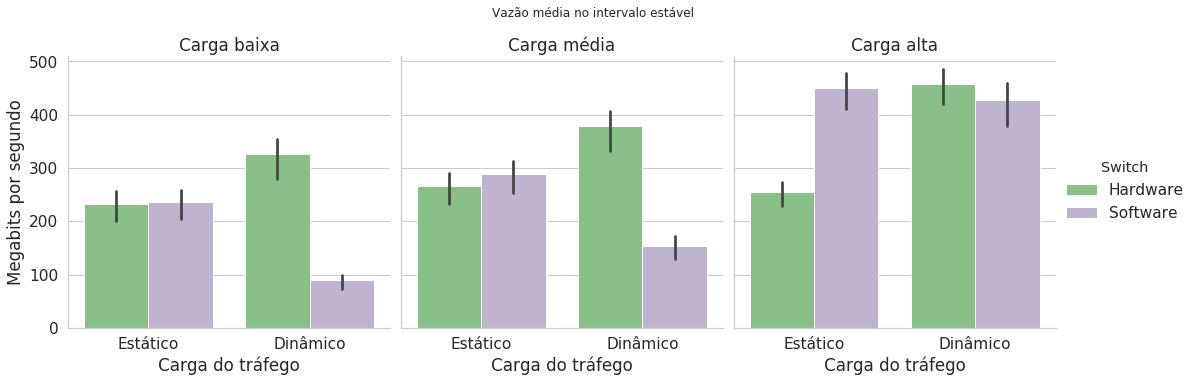

In [7]:
#Trafego em cada switch no intervalo estavel
#inicio = 18
#display(dfTotal_info.query("Medicao >= @inicio and Medicao <= 48"))
gpb = dfTotal_info.groupby(["Metodo", "TempoChegada", "Switch", "Medicao", "Seed"]).mean()
gpb['Total'] = 0
gpb.reset_index(inplace=True)
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and (row['Medicao'] != b and row['Medicao'] != c)):
            gpb.drop(index, inplace=True)
#Calculando o total transmitido no intervalo estavel
#(bytesenviados no fim-inicio porque bytesenviados é acumulativo)
totalHW = 0
totalSW = 0
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "HW"):
            totalHW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "HW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalHW
            totalHW = 0
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "SW"):
            totalSW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "SW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalSW
            totalSW = 0
gpb = gpb[gpb.Total != 0]
#Plotando grafico
gpb["MbSeg"] = gpb["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb["NomeSwitch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
sns_plt = sns.catplot(palette="Accent", x="Metodo", y="MbSeg", kind="bar", ci=95, data=gpb, col="NomeTempo", hue="NomeSwitch", col_order=["baixa", "média", "alta"], order=["Estático", "Dinâmico"])
#sns_plt.set(ylim=(0, 350))
sns_plt.fig.suptitle('Vazão média no intervalo estável', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Megabits por segundo")
sns_plt.set_titles("Carga {col_name}")
sns_plt._legend.set_title("Switch")
if (salvarGraficos):
    sns_plt.savefig("VazaoMediaIntervaloEstavelPorSwitch.pdf")

Na vazão média, vemos o comportamento esperado dos dois métodos. Para uma carga baixa, o método estático divide perfeitamente a carga da rede entre os dois switches, enquanto o método dinâmico coloca os maiores tráfegos no switch de hardware, já que o mesmo quase sempre possui espaço na sua tabela de regras e pode aceitar tráfegos, logo os tráfegos que nao são movidos e continuam no switch de software tem vazão muito baixa, isso explica a menor vazão do switch neste método. Como não houve bloqueio neste cenário, toda a demanda da rede foi atendida.
Já na carga alta, o comportamento é diferente, porém também dentro do esperado. Devido a taxa de bloqueio de tráfegos no método estático, a vazão no switch de hardware é bem menor do que a do switch de software, dado que novos tráfegos são bloqueados após o limite de regras ser atingido. Como no método dinâmico as condições bloqueio não acontecem, vemos um grande aumento de vazão no switch de hardware e uma leve diminuição na vazão do switch de software, já que os maiores tráfegos são sempre enviados para o switch de hardware, caso o mesmo tenha espaço na sua tabela.

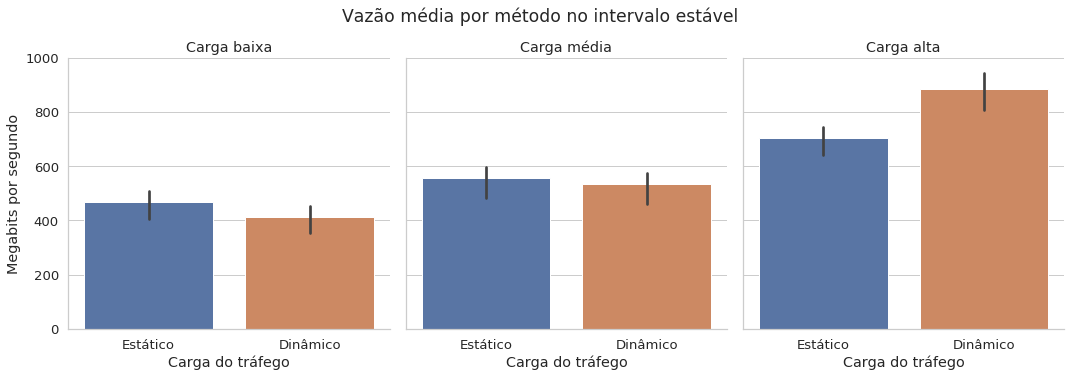

In [8]:
gpb2 = gpb.groupby(["Metodo", "TempoChegada", "Seed"]).sum()
gpb2["MbSeg"] = gpb2["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb2.reset_index(inplace=True)
sns.set(font_scale=1.2, style="whitegrid")
gpb2["NomeTempo"] = gpb2["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
sns_plt = sns.catplot(x="Metodo", y="MbSeg", kind="bar", ci=95, data=gpb2, col="NomeTempo", col_order=["baixa", "média","alta"], order=["Estático", "Dinâmico"])
sns_plt.set(ylim=(0, 1000))
sns_plt.fig.suptitle('Vazão média por método no intervalo estável', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Megabits por segundo")
sns_plt.set_titles("Carga {col_name}")
if (salvarGraficos):
    sns_plt.savefig("VazaoIntervaloEstavelPorMetodo.pdf")

Este gráfico é a soma das duas barras de cada switch do gráfico anterior, mostrando a vazão total em cada método. Vemos um aumento considerável na vazão na carga alta. Os métodos estático e dinâmico possuem uma vazão estatisticamente igual para as cargas média e baixa, o que mostra a melhora no método dinâmico comparado ao estático.

In [9]:
#Pegando portas no intervalo estavel
dfIperf = pd.DataFrame()
for i in range(len(seeds)):
    dfIperf_temp = pd.read_csv("../Saidas/teste"+(str(i+1))+"_pi010/iperfs.txt", sep="\t")
    dfIperf_temp['Seed'] = seeds[i]
    dfIperf = pd.concat([dfIperf, dfIperf_temp], ignore_index=True)
portasEstaveis010 = []
portasEstaveis020 = []
portasEstaveis030 = []
for a, b, c in intervalosTempo:
    for index, row in dfIperf.iterrows():
        if (row['Inicio(seg)'] >= b and row['Inicio(seg)'] <= c):
            if (a == "010"):
                portasEstaveis010.append(int(row['PCli']))
            elif (a == "020"):
                portasEstaveis020.append(int(row['PCli']))
            elif (a == "030"):
                portasEstaveis030.append(int(row['PCli']))

#Remove os duplicados das listas
def remove_duplicados(lista_duplicada): 
    lista = [] 
    for porta in lista_duplicada:
        if porta not in lista:
            lista.append(porta) 
    return lista

portasEstaveis010 = remove_duplicados(portasEstaveis010)
portasEstaveis020 = remove_duplicados(portasEstaveis020)
portasEstaveis030 = remove_duplicados(portasEstaveis030)

In [10]:
gpb = dfServer.groupby(["Metodo", "PortaOri", "PortaDest", "TempoChegada"]).mean()
gpb.reset_index(inplace=True)
dfEstavel = gpb
for index, row in gpb.iterrows():
    if (not(int(row['PortaDest']) in portasEstaveis010) and row['TempoChegada'] == "010"):
        dfEstavel.drop(index, inplace=True)
    elif (not(int(row['PortaDest']) in portasEstaveis020) and row['TempoChegada'] == "020"):
        dfEstavel.drop(index, inplace=True)
    elif (not(int(row['PortaDest']) in portasEstaveis030) and row['TempoChegada'] == "030"):
        dfEstavel.drop(index, inplace=True)

In [11]:
# #Trafego no intervalo estavel em cada metodo
# # display(dfEstavel)
# gpb = dfEstavel.groupby(["Metodo","TempoChegada"]).sum()
# gpb["MbSeg"] = gpb["BytesEnv"]/125000/tempoEstavel
# gpb.reset_index(inplace=True)
# gpb["Carga"] = gpb["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
# gpb["NomeMetodo"] = gpb["Metodo"].map({"SW": "Dinâmico", "PI": "Estático"})
# sns_plt = sns.catplot(x="NomeMetodo", y="MbSeg", kind="bar", ci=95, data=gpb, col="Carga")
# #sns_plt = sns.catplot(x="Metodo", y="MbSeg", kind="bar", ci=95, data=gpb, col="NomeTempo")
# sns_plt.fig.suptitle('Vazão por método no intervalo estável', y=1.05)
# sns_plt.set_axis_labels("Carga do tráfego", "Megabits por segundo")
# sns_plt.set(ylim=(0, 600))
# sns_plt.set_titles("Carga {col_name}")
# if (salvarGraficos):
#     sns_plt.savefig("VazaoIntervaloEstavelCSV.pdf")

In [12]:
# #Perda de pacotes no intervalo estavel
# #Carga alta
# print ("Porcentagem de perda carga alta:")
# inicio = np.min(portasEstaveis010)
# fim = np.max(portasEstaveis010)
# gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '010'")
# min = gpb.groupby("Metodo").min()['%Perda']
# med = gpb.groupby("Metodo").mean()['%Perda']
# max = gpb.groupby("Metodo").max()['%Perda']
# table = [min, med, max]
# rowIDs = ["Mínimo", "Média", "Máximo"]
# print(tabulate(table, headers=["Estático","Dinâmico"], showindex=rowIDs, tablefmt="grid", floatfmt=(".2e")))

# #Carga media
# print ("\n\nPorcentagem de perda carga média:")
# inicio = np.min(portasEstaveis020)
# fim = np.max(portasEstaveis020)
# gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '020'")
# min = gpb.groupby("Metodo").min()['%Perda']
# med = gpb.groupby("Metodo").mean()['%Perda']
# max = gpb.groupby("Metodo").max()['%Perda']
# table = [min, med, max]
# rowIDs = ["Mínimo", "Média", "Máximo"]
# print(tabulate(table, headers=["Estático","Dinâmico"], showindex=rowIDs, tablefmt="grid", floatfmt=(".2e")))

# #Carga baixa
# print ("\n\nPorcentagem de perda carga baixa:")
# inicio = np.min(portasEstaveis030)
# fim = np.max(portasEstaveis030)
# gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '030'")
# min = gpb.groupby("Metodo").min()['%Perda']
# med = gpb.groupby("Metodo").mean()['%Perda']
# max = gpb.groupby("Metodo").max()['%Perda']
# table = [min, med, max]
# rowIDs = ["Mínimo", "Média", "Máximo"]
# print(tabulate(table, headers=["Estático","Dinâmico"], showindex=rowIDs, tablefmt="grid", floatfmt=(".2e")))

In [13]:
#Pacotes fora de ordem no intervalo estavel
#Carga alta
print ("Pacotes fora de ordem carga alta:")
inicio = np.min(portasEstaveis010)
fim = np.max(portasEstaveis010)
gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '010'")
min = gpb.groupby("Metodo").min()['ForaOrdem']
med = gpb.groupby("Metodo").mean()['ForaOrdem']
max = gpb.groupby("Metodo").max()['ForaOrdem']
table = [min, med, max]
rowIDs = ["Mínimo", "Média", "Máximo"]
print(tabulate(table, headers=["Estático","Dinâmico"], showindex=rowIDs, tablefmt="grid"))

#Carga media
print ("\n\nPacotes fora de ordem carga média:")
inicio = np.min(portasEstaveis020)
fim = np.max(portasEstaveis020)
gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '020'")
min = gpb.groupby("Metodo").min()['ForaOrdem']
med = gpb.groupby("Metodo").mean()['ForaOrdem']
max = gpb.groupby("Metodo").max()['ForaOrdem']
table = [min, med, max]
rowIDs = ["Mínimo", "Média", "Máximo"]
print(tabulate(table, headers=["Estático","Dinâmico"], showindex=rowIDs, tablefmt="grid"))

#Carga baixa
print ("\n\nPacotes fora de ordem carga baixa:")
inicio = np.min(portasEstaveis030)
fim = np.max(portasEstaveis030)
gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '030'")
min = gpb.groupby("Metodo").min()['ForaOrdem']
med = gpb.groupby("Metodo").mean()['ForaOrdem']
max = gpb.groupby("Metodo").max()['ForaOrdem']
table = [min, med, max]
rowIDs = ["Mínimo", "Média", "Máximo"]
print(tabulate(table, headers=["Estático","Dinâmico"], showindex=rowIDs, tablefmt="grid"))

Pacotes fora de ordem carga alta:
+--------+------------+------------+
|        |   Estático |   Dinâmico |
+========+============+============+
| Mínimo | 0          |  0         |
+--------+------------+------------+
| Média  | 0.00297579 |  0.0684995 |
+--------+------------+------------+
| Máximo | 8          | 83         |
+--------+------------+------------+


Pacotes fora de ordem carga média:
+--------+-------------+------------+
|        |    Estático |   Dinâmico |
+========+=============+============+
| Mínimo | 0           |          0 |
+--------+-------------+------------+
| Média  | 0.000191975 |          0 |
+--------+-------------+------------+
| Máximo | 1           |          0 |
+--------+-------------+------------+


Pacotes fora de ordem carga baixa:
+--------+------------+------------+
|        |   Estático |   Dinâmico |
+========+============+============+
| Mínimo |          0 |          0 |
+--------+------------+------------+
| Média  |          0 |         

In [14]:
#Lendo os arquivos de ping
def pings(dfP, metodo, switch):
    for s in range(len(seeds)):
        for tempo in tempos:
            path = "../Saidas/teste"+(str(s+1))+"_"+(metodo)+(tempo)+"/ping"+switch+".txt" #caminho do arquivo
            with open(path) as stream:#Abre o arquivo
                times = [] #lista que armazenara todos os pings para coloca-los posteriormente em um series->dataframe
                next(stream)  # Ignora a primeira linha do arquivo de entrada
                for line in stream: #Pega todas as linhas
                    string = line.split(" ") #String eh uma lista com cada palavra da linha
                    if(line != "Request timed out\n"): #Se a linha tiver o ping
                        for i in range(0,len(string)): #Para cada palavra na lista string, procura "time"
                            if(re.match(r'time', string[i])): #Pega somente os valores numericos da palavra
                                time = re.findall(r'\d.+', string[i])
                                times.append(float(time[0])) #Transforma-os para float e coloca-os na lista times
                series = pd.Series(times) #Transforma a lista em uma Series
                ds = pd.DataFrame(series, columns=['Ping']) # E por fim em um dataframe
                ds['Seed'] = seeds[s]
                ds['Tempo'] = tempo
                ds['Metodo'] = metodo
                ds['Switch'] = switch
                dfP = pd.concat([dfP, ds])
    return dfP

dfPing = pd.DataFrame(columns=['Ping', 'Seed', 'Tempo', 'Metodo', 'Switch'])
dfPPIHW = pings(dfPing, 'pi', 'HW')
dfPPISW = pings(dfPing, 'pi', 'SW')
dfPSWHW = pings(dfPing, 'sw', 'HW')
dfPSWSW = pings(dfPing, 'sw', 'SW')
dfPing = pd.concat([dfPing, dfPPIHW, dfPPISW, dfPSWHW, dfPSWSW])
dfPing.reset_index(inplace=True)
del dfPing['index']

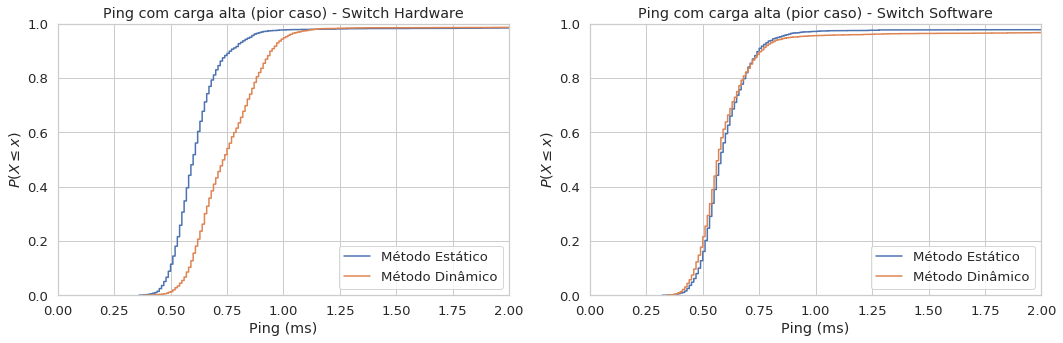

In [15]:
#CDF do ping
#Query
dfPingHW_CAPI = dfPing.query("Metodo == 'pi' and Tempo == '010' and Switch == 'HW'")
dfPingHW_CASW = dfPing.query("Metodo == 'sw' and Tempo == '010' and Switch == 'HW'")
dfPingSW_CAPI = dfPing.query("Metodo == 'pi' and Tempo == '010' and Switch == 'SW'")
dfPingSW_CASW = dfPing.query("Metodo == 'sw' and Tempo == '010' and Switch == 'SW'")
#HW
hw_a = dfPingHW_CAPI.Ping.to_numpy()
hw_b = dfPingHW_CASW.Ping.to_numpy()
hw_x = np.sort(hw_a)
hw_x1 = np.sort(hw_b)
hw_ecdf = sm.distributions.ECDF(hw_a)
hw_ecdf1 = sm.distributions.ECDF(hw_b)
hw_y = hw_ecdf(hw_x)
hw_y1 = hw_ecdf1(hw_x1)
#SW
sw_a = dfPingSW_CAPI.Ping.to_numpy()
sw_b = dfPingSW_CASW.Ping.to_numpy()
sw_x = np.sort(sw_a)
sw_x1 = np.sort(sw_b)
sw_ecdf = sm.distributions.ECDF(sw_a)
sw_ecdf1 = sm.distributions.ECDF(sw_b)
sw_y = sw_ecdf(sw_x)
sw_y1 = sw_ecdf1(sw_x1)
#Graficos
#HW
plt.subplot(1, 2, 1)
plt.step(hw_x, hw_y, where='post', label="Método Estático")
plt.step(hw_x1, hw_y1, where='post', label="Método Dinâmico")
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Ping (ms)')
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Ping com carga alta (pior caso) - Switch Hardware')
#SW
plt.subplot(1, 2, 2)
plt.step(sw_x, sw_y, where='post', label="Método Estático")
plt.step(sw_x1, sw_y1, where='post', label="Método Dinâmico")
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Ping (ms)')
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.title('Ping com carga alta (pior caso) - Switch Software')
#Tamanho
fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.tight_layout()
if (salvarGraficos):
    plt.savefig('pingCargaAlta.pdf')
plt.show()

Com a vantagem de vazão estabelecida, devemos olhar também para a qualidade da rede, pois esta é um fator importante no uso. A função de distribuição cumulativa dos pings em ambos switches no pior caso (carga alta) mostra uma pequena vantagem do método estático se o switch de hardware for analisado e tal vantagem não se repete no switch de software.
Esta vantagem se deve a natureza dos métodos, onde no método estático o switch de hardware bloqueia tráfegos, e consequentemente, não é tão carregado quanto no método dinâmico, onde o switch de hardware é atribuído os maiores tráfegos em um determinado momento na rede, sobrecarregando um pouco mais o switch.